<a href="https://colab.research.google.com/github/Suvoo/CodeForCause/blob/main/Workshop-DeepLearning/Copy_of_DSC_CNN1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NeuRes
## Making a binary classifier to distinguish between Dogs & Cats

In [ ]:
#IMPORT ALL REQUIRED LIBRARIES
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
#DOWNLOAD THE DATASET
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  67.4M      0  0:00:11  0:00:11 --:--:-- 82.2M


In [ ]:
#UNZIPPING DATASET INTO DIRECTORY
!unzip -q kagglecatsanddogs_3367a.zip

In [ ]:
!ls

 kagglecatsanddogs_3367a.zip   PetImages        sample_data
'MSR-LA - 3467.docx'	      'readme[1].txt'


In [ ]:
!ls PetImages

Cat  Dog


In [ ]:
#CLEANING THE DATA BY DELETING THE CORRUPTED FILES
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [ ]:
#DEFINING IMAGE AND BATCH SIZE
image_size = (180, 180)
batch_size = 32

#SPLITTING THE DATASET INTO TRAIN AND TEST
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


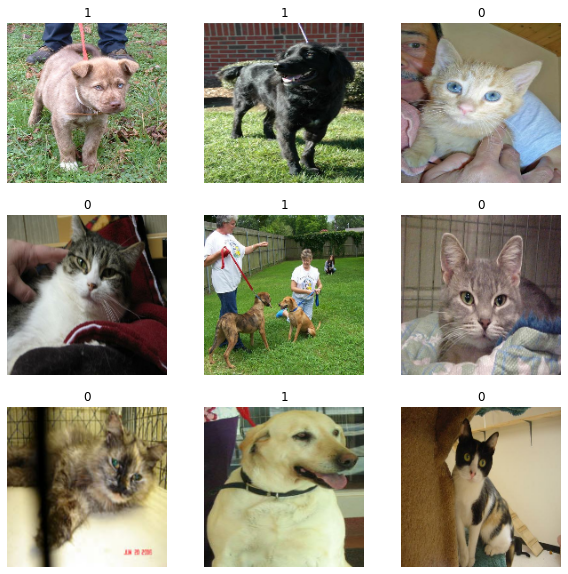

In [ ]:
#PREVIEW OF THE DATA
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
#DATA AUGMENTATION
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

# for more information about data augmentation refer this link: https://www.mygreatlearning.com/blog/understanding-data-augmentation/

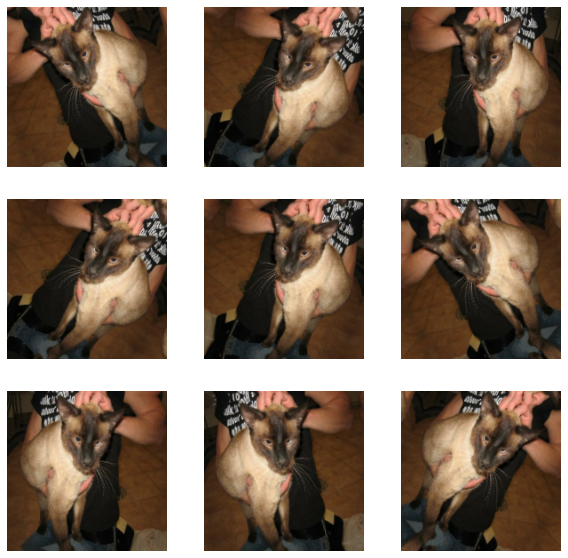

In [ ]:
#WHAT HAPPENS TO IMAGE AFTER AUGMENTATION
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
#CREATING A BUFFER FOR OUR DATASET
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

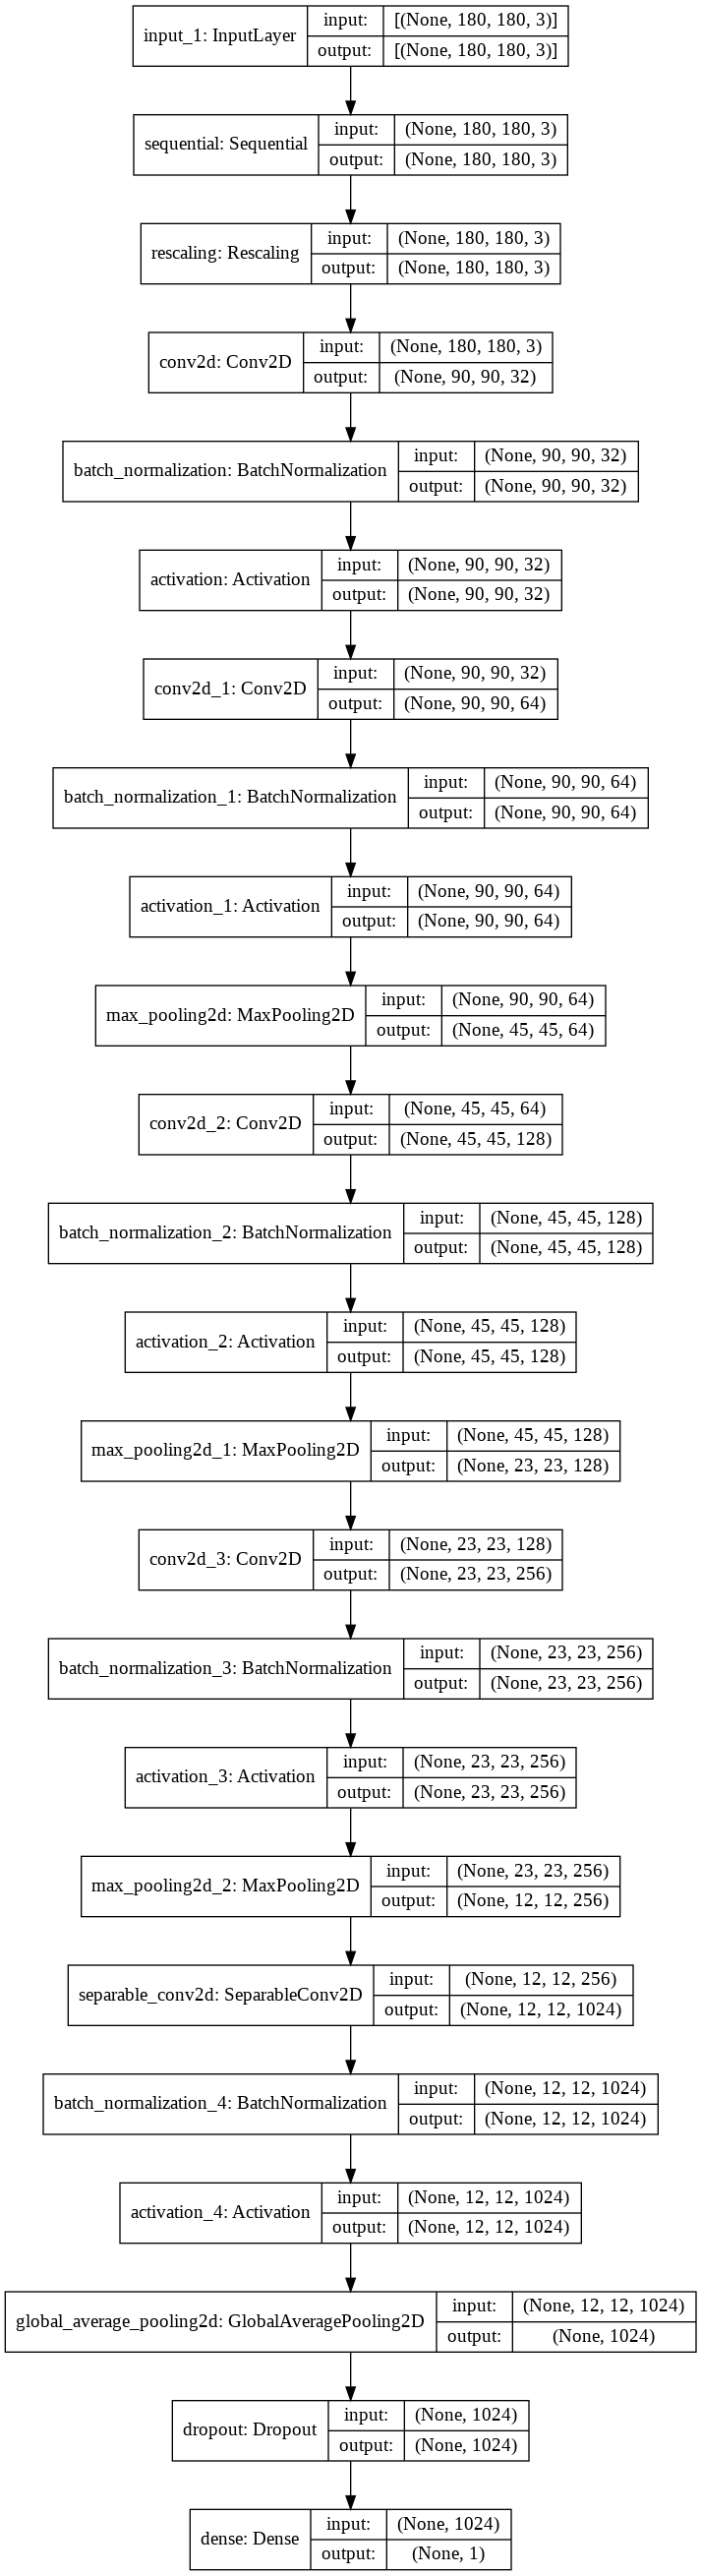

In [ ]:
#MAKING OUR MODEL
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x) '''Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. 
                                    This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.'''
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    x = layers.Conv2D(128, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    x = layers.Conv2D(256, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)    

    x = layers.SeparableConv2D(1024, 3, padding="same")(x) '''SeparableConv2D is a variation of the traditional convolution that was proposed to compute it faster.
                                                It performs a depthwise spatial convolution followed by a pointwise convolution which mixes together the resulting output channels.'''
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2: # binary
        activation = "sigmoid"
        units = 1
    else: # multiclass
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x) #adding last output layer with number of nodes = number of classes
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 5  #number of epochs

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),  #optimzer and learning rate
    loss="binary_crossentropy", #binary
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
) #training

Epoch 1/5
586/586 [==============================] - 96s 112ms/step - loss: 0.6591 - accuracy: 0.6255 - val_loss: 0.6781 - val_accuracy: 0.6461
Epoch 2/5
586/586 [==============================] - 66s 111ms/step - loss: 0.4739 - accuracy: 0.7707 - val_loss: 1.9020 - val_accuracy: 0.5000
Epoch 3/5
586/586 [==============================] - 65s 111ms/step - loss: 0.3951 - accuracy: 0.8171 - val_loss: 0.6271 - val_accuracy: 0.6771
Epoch 4/5
586/586 [==============================] - 66s 111ms/step - loss: 0.3365 - accuracy: 0.8538 - val_loss: 0.5445 - val_accuracy: 0.7033
Epoch 5/5
586/586 [==============================] - 66s 112ms/step - loss: 0.2948 - accuracy: 0.8735 - val_loss: 0.3839 - val_accuracy: 0.8133


In [ ]:
#INFERENCE
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 99.58 percent cat and 0.42 percent dog.


#### Link to advanced notebook: https://colab.research.google.com/drive/1kL5FamggcOjb_x61NY-EUpELrnPTw3tI?usp=sharing